In [1]:
import torch
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import residual_GAN
from image_dataset import image_dataset
from torch.utils.data import RandomSampler
from torch_snippets import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
path_gen = r"resnet_300M_generator/"
path_disc = r"resnet_300M_discriminator/"
discriminator = residual_GAN.Discriminator().to(device)
discriminator.load_state_dict(torch.load(path_disc+"discriminator.pth"))
generator = residual_GAN.Generator(noise_dim=2048).to(device)
generator.load_state_dict(torch.load(path_gen+"generator.pth"))

<All keys matched successfully>

# Data Pipeline and Utility Functions

In [3]:
def noise_generator(device,batch_size=64, dimension=2048):
    return torch.randn((batch_size, dimension)).to(device)

# training routine

In [4]:
model_name = "resnet_300M_generator"
if not os.path.exists(model_name):
    os.makedirs(model_name)

In [5]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(generator.parameters(),lr=5e-6)

In [6]:
def train_generator(discriminator,fake_data,loss_fn,optimizer):
    optimizer.zero_grad()
    pred = discriminator(fake_data)
    loss = loss_fn(pred,torch.ones(len(fake_data),1).to(device))
    loss.backward()
    optimizer.step()
    return loss

EPOCH: 1.000  g_loss: 4.765  (165.80s - 1492.23s remaining)
EPOCH: 2.000  g_loss: 0.310  (330.22s - 1320.90s remaining)
EPOCH: 3.000  g_loss: 0.063  (492.87s - 1150.03s remaining)
EPOCH: 4.000  g_loss: 0.030  (653.44s - 980.15s remaining))


100%|██████████| 111/111 [00:00<00:00, 4616.21it/s]


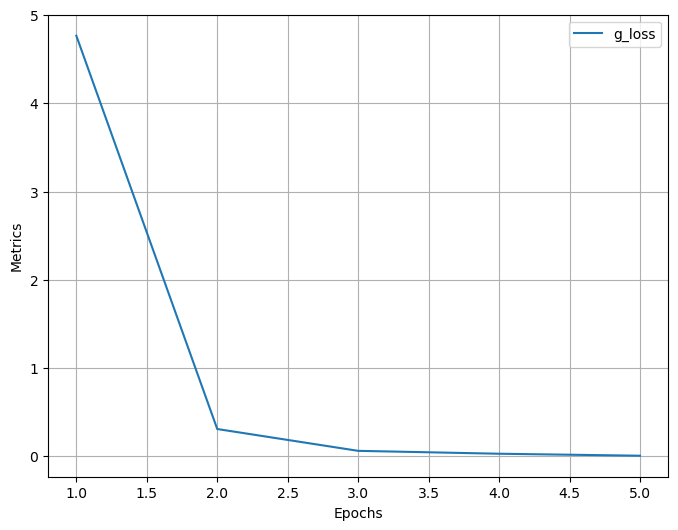

In [7]:
N = 500
noise_dim = 2048
batch_size=64
num_epochs = 10
log = Report(num_epochs)
threshold = 0.1
loss_total = 0
num_batchs = 0
count = 0
num_count = 2
for epoch in range(num_epochs):
    for idx in range(N):
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        loss = train_generator(discriminator, fake_data, loss_fn, optimizer)
        loss_total += loss.item()
        num_batchs += 1
        log.record(epoch+(1+idx)/N,g_loss = loss.item(), end='\r')
    log.report_avgs(epoch+1)
    if (loss_total/num_batchs) < threshold:
        count += 1
        if count == num_count:
            torch.save(generator.state_dict(),model_name+"/generator.pth")
            break
    else:
        count = 0
    loss_total = 0
    num_batchs = 0

log.plot_epochs(['g_loss'])

In [31]:
generator.to('cpu')
discriminator.to('cpu')
img = generator(noise_generator('cpu',1,2048))
p = torch.nn.Sigmoid()(discriminator(img))[0][0]
p

tensor(0.3443, grad_fn=<SelectBackward0>)

0.46452900767326355

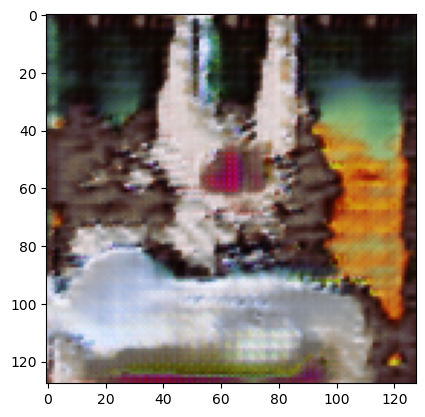

In [32]:
p = torch.nn.Sigmoid()(discriminator(img))[0][0]
print(p.item())
img2 = img.detach().cpu().numpy()
img3 = img2.squeeze()
img3 = img3.transpose(1,2,0)
plt.imshow(img3)

In [16]:
generator.to('cpu')
fake_data = generator(noise_generator('cpu',10,2048))
fake_data.shape

torch.Size([10, 3, 128, 128])

In [127]:
discriminator.to('cpu')
pred_fake = discriminator(fake_data).to('cpu')
print(pred_fake)
print(nn.Sigmoid()(pred_fake))
loss_fake = loss_fn(pred_fake,torch.ones((len(fake_data),1)))
print(loss_fake)

tensor([[-2.3583],
        [-2.9432],
        [-3.8147],
        [-3.5493],
        [-2.6562],
        [-2.9542],
        [-3.5420],
        [-3.0184],
        [-3.1406],
        [-3.1986]], grad_fn=<AddmmBackward0>)

tensor([[0.0864],
        [0.0501],
        [0.0216],
        [0.0279],
        [0.0656],
        [0.0495],
        [0.0281],
        [0.0466],
        [0.0415],
        [0.0392]], grad_fn=<SigmoidBackward0>)

tensor(3.1645, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)